<a href="https://colab.research.google.com/github/PhuwadolSuphapinyo/steamlit-time-series/blob/master/Prediction_Stock_Prices_on_the_SET(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM

In [53]:
%%capture
!pip install starfishX
!pip install mplfinance

In [ ]:
import pandas as pd
import numpy as np
import starfishX as sx
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
%matplotlib inline

In [ ]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
symbol = 'BANPU'
df = sx.loadHistData_v2(symbol, start='1999-08-19', end=today)
df.reset_index(inplace=True)

ทำนายหุ้น BANPU โดยมีข้อมูลตั้งแต่วันที่ 04/01/2000

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,2.096010,2.133776,2.077127,2.077127,0.647383,13379778
1,2000-01-05,2.001595,2.020478,1.926063,1.963829,0.612071,10406199
2,2000-01-06,1.963829,1.982712,1.907180,1.963829,0.612071,12032003
3,2000-01-07,1.963829,2.020478,1.907180,1.926063,0.600300,13677665
4,2000-01-10,1.926063,1.963829,1.812765,1.812765,0.564989,12503327
...,...,...,...,...,...,...,...
5924,2023-11-13,7.600000,8.000000,7.550000,8.000000,8.000000,123532500
5925,2023-11-14,7.950000,8.100000,7.900000,8.050000,8.050000,119659500
5926,2023-11-15,8.100000,8.200000,8.000000,8.150000,8.150000,149877100
5927,2023-11-16,8.100000,8.200000,8.000000,8.100000,8.100000,74372800


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5929 entries, 0 to 5928
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5929 non-null   datetime64[ns]
 1   Open       5929 non-null   float64       
 2   High       5929 non-null   float64       
 3   Low        5929 non-null   float64       
 4   Close      5929 non-null   float64       
 5   Adj Close  5929 non-null   float64       
 6   Volume     5929 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 324.4 KB


In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5.929000e+03
mean,17.697372,17.914516,17.458641,17.670910,10.445265,4.094937e+07
std,13.607823,13.736122,13.457246,13.583958,7.446319,5.357682e+07
min,1.114095,1.170744,1.095212,1.151861,0.359003,0.000000e+00
25%,9.819146,9.950000,9.668082,9.819146,4.907126,1.163932e+07
50%,13.800000,13.973400,13.600000,13.746805,10.039160,2.317300e+07
75%,21.904249,22.100000,21.600000,21.904249,13.804506,4.720522e+07
max,65.108498,65.561684,64.353172,64.655304,35.093418,7.592047e+08


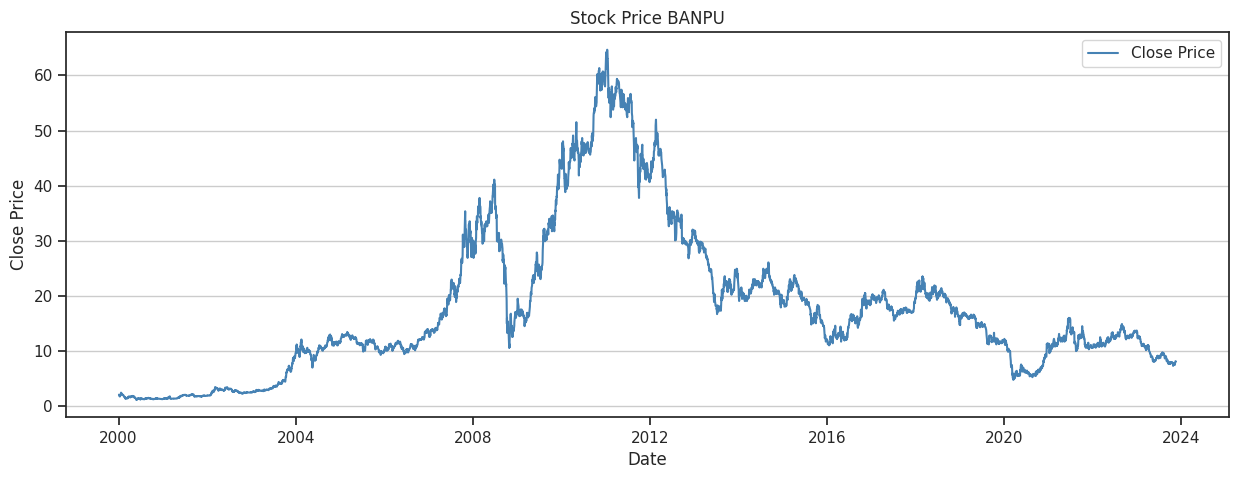

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Close'], label='Close Price', color='steelblue', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price BANPU')
plt.grid(axis='y')
plt.legend()
plt.show()


Train test spilt

In [ ]:
# สร้างตารางใหม่ที่ไม่มีคอลัมน์ 'Close'
data = df.filter(['Close'])
# Convert dataframe ให้เป็น numpy array
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .70))
training_data_len

4151

In [ ]:
dataset

array([[2.077127],
       [1.963829],
       [1.963829],
       ...,
       [8.15    ],
       [8.1     ],
       [8.1     ]])

In [ ]:
dataset.shape

(5929, 1)

Normalization
คอลัมน์ 'Volume' มีค่าที่โดดไปจากคอลัมน์อื่นๆเพื่อไม่ให้โมเดลมีการเอนเอียงเลยต้องทำการ Scale

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01457033],
       [0.0127862 ],
       [0.0127862 ],
       ...,
       [0.11020094],
       [0.10941358],
       [0.10941358]])

In [ ]:
# Train_set และ scale
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
      print(x_train)
      print(y_train)
      print()

# เปลี่ยน x_train และ y_train เป็น numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.01457033, 0.0127862 , 0.0127862 , 0.0121915 , 0.01040737,
       0.00921796, 0.01011002, 0.01040737, 0.01248885, 0.01248885,
       0.01397562, 0.01457033, 0.01813856, 0.02022004, 0.01903062,
       0.01784121, 0.0172465 , 0.01575974, 0.01635444, 0.01575974,
       0.01575974, 0.01516504, 0.01397562, 0.01397562, 0.0127862 ,
       0.0127862 , 0.01248885, 0.0127862 , 0.0121915 , 0.01070473,
       0.00921796, 0.00862325, 0.00773119, 0.00802854, 0.00802854,
       0.00564971, 0.00594706, 0.0038656 , 0.00535236, 0.0038656 ,
       0.00327089, 0.00267619, 0.00475765, 0.00535236, 0.005055  ,
       0.00446031, 0.00475765, 0.005055  , 0.00475765, 0.00446031,
       0.005055  , 0.00416296, 0.00416296, 0.00535236, 0.00743383,
       0.00624442, 0.00713648, 0.0089206 , 0.00862325, 0.00862325])]
[0.008920602934867641]

[array([0.01457033, 0.0127862 , 0.0127862 , 0.0121915 , 0.01040737,
       0.00921796, 0.01011002, 0.01040737, 0.01248885, 0.01248885,
       0.01397562, 0.01457033, 0.0

In [ ]:
# สร้าง test_data และ scale
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# เปลี่ยน x_test เป็น numpy arrays
x_test = np.array(x_test)

# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test

array([[[0.17870116],
        [0.18342531],
        [0.17870116],
        ...,
        [0.235391  ],
        [0.22751741],
        [0.22909213]],

       [[0.18342531],
        [0.17870116],
        [0.17712644],
        ...,
        [0.22751741],
        [0.22909213],
        [0.22909213]],

       [[0.17870116],
        [0.17712644],
        [0.1818506 ],
        ...,
        [0.22909213],
        [0.22909213],
        [0.235391  ]],

       ...,

       [[0.1204366 ],
        [0.12122396],
        [0.11964924],
        ...,
        [0.10311471],
        [0.10783886],
        [0.10862622]],

       [[0.12122396],
        [0.11964924],
        [0.1204366 ],
        ...,
        [0.10783886],
        [0.10862622],
        [0.11020094]],

       [[0.11964924],
        [0.1204366 ],
        [0.12122396],
        ...,
        [0.10862622],
        [0.11020094],
        [0.10941358]]])

LSTM - (Long Short-Term Memory)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# สร้างโมเดล LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train โมเดล
History = model.fit(x_train, y_train, batch_size=5 , epochs=5, validation_split=0.2)

Epoch 1/5
655/655 [==============================] - 56s 78ms/step - loss: 0.0015 - val_loss: 2.0254e-04
Epoch 2/5
655/655 [==============================] - 49s 75ms/step - loss: 4.1884e-04 - val_loss: 1.4273e-04
Epoch 3/5
655/655 [==============================] - 50s 77ms/step - loss: 3.2228e-04 - val_loss: 1.3653e-04
Epoch 4/5
655/655 [==============================] - 49s 75ms/step - loss: 2.7678e-04 - val_loss: 8.9530e-05
Epoch 5/5
655/655 [==============================] - 49s 75ms/step - loss: 2.5177e-04 - val_loss: 9.1918e-05


In [ ]:
# สร้าง test_data และ scale
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# เปลี่ยน x_test เป็น numpy arrays
x_test = np.array(x_test)

# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predicton
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

56/56 [==============================] - 7s 97ms/step


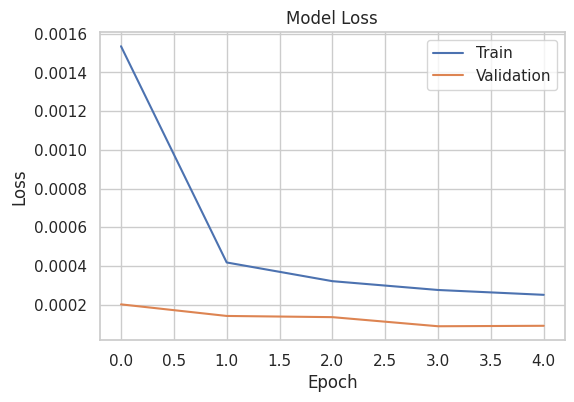

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

sns.lineplot(data=History.history['loss'], label='Train')
sns.lineplot(data=History.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<ipython-input-49-2a3bdfc7b4f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


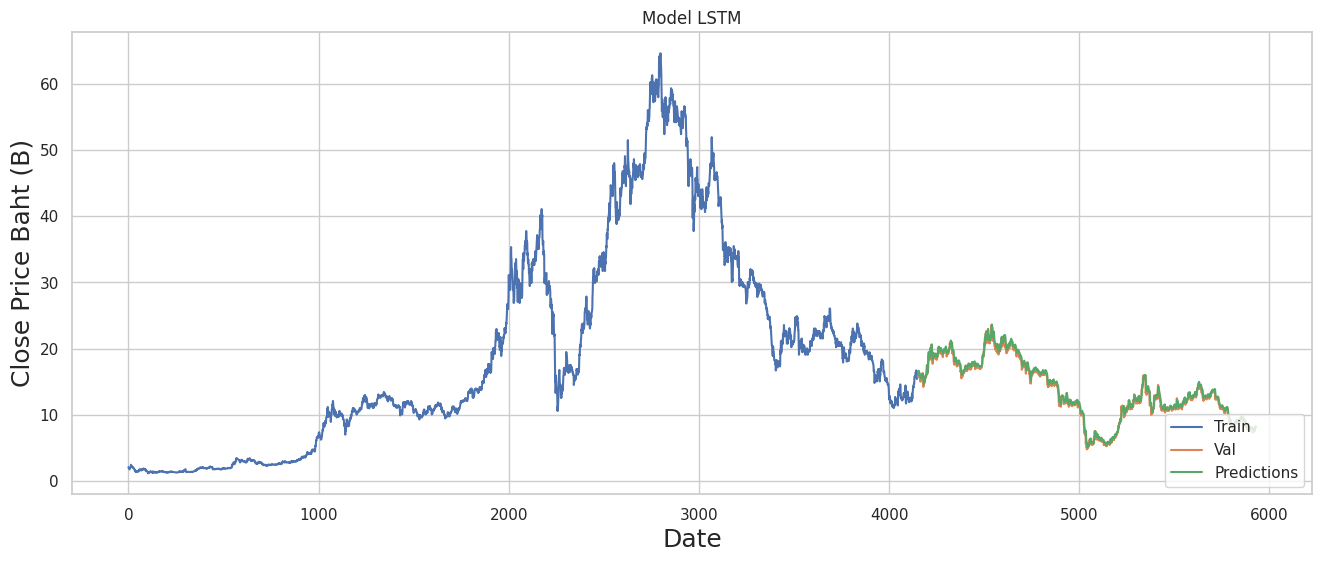

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('Model LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Baht (B)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,Close,Predictions
4151,15.700000,15.967019
4152,16.100000,15.971200
4153,16.600000,16.140022
4154,16.200001,16.485409
4155,16.500000,16.559525
...,...,...
5924,8.000000,7.770866
5925,8.050000,7.927115
5926,8.150000,8.071523
5927,8.100000,8.194118


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [54]:
#  Root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) **2)))

# R2 Score
R2=r2_score(y_test, predictions)

# Mean Squared Error (MSE)
mse =mean_squared_error(predictions, y_test)

print(f'Root mean squared error (RMSE): {rmse}')
print(f'R-squared (R2):                 {R2}')
print(f'Mean absolute error (MAE):      {mse}')

Root mean squared error (RMSE): 0.432737613157578
R-squared (R2):                 0.9905327425224838
Mean absolute error (MAE):      0.18726184184131764
